# Plot for Summary Report: PCA and K-Means Clustering

In [1]:
%run 'helpers-for-report-plot-generation.ipynb'
from datetime import datetime

In [82]:
def get_raw_data():
    """Get raw data from local database"""
    milk = get_dataset('milk_volume')
    birthdates = get_dataset('birthdates')
    genetics = get_dataset('genetics')
    classification = get_dataset('classification')
        
    return milk, birthdates, genetics, classification

def transform_milk(data):
    """Transform milk features"""
    features = ['animal_id','date','milk_weight']
    return data[features]

def transform_genetics(data):
    """Transform and select genetics features"""
    data = data.drop(axis=1, labels=['name'])
    print('\nCurrently Available Genetics Features: \n', data.columns.values)
    features = ['animal_id', 'milk', 'ctpi', 'udc']
    print('\nSelected Genetics Features: \n', features)
    data = data.drop_duplicates(subset=['animal_id'], keep='last')
    return data.fillna(data.mean())[features]

def transform_classification(data):
    """Transform and select classification features"""
    data = data.drop(axis=1, labels=['category', 'age', 'date_calved', 'date'])
    print('\nCurrently Available Classification Features: \n', data.columns.values)
    features = ['animal_id', 'final_score', 'breed_age_average', 'dairy_strength_aggregate', 'body_condition']
    print('\nSelected Classification Features: \n', features)
    data = data.drop_duplicates(subset=['animal_id'], keep='last')
    return data.fillna(data.mean())[features]

def number_of_days_in_period(start, end):
    """Gets number of days between two string dates"""
    end = datetime.strptime(end, '%m-%d-%Y')
    start = datetime.strptime(start, '%m-%d-%Y')
    return (start - end).days

def build_performance_profiles_for_period(milk, birthdates, start='1-1-2016', end='12-31-2017'):
    """Build summary performance profiles for date range"""
    period_milk = milk.set_index('date')[start:end]
    period_milk = pd.merge(left=period_milk, right=birthdates, left_on='animal_id', right_on='animal_id')
    
    days_in_period = number_of_days_in_period(start, end)
    
    profiles = []
    for animal_id in period_milk['animal_id'].unique():
        animal_milk_for_period = period_milk[period_milk['animal_id'] ==  animal_id]
        
        profile = {}
        profile['animal_id'] = animal_id 
        profile['days_milked'] = animal_milk_for_period.count()['animal_id']
        profile['total_milkweight'] = animal_milk_for_period['milk_weight'].sum()
        profile['daily_milkweight'] = round(animal_milk_for_period['milk_weight'].mean(), 2)
        
        birthdate = pd.to_datetime(animal_milk_for_period['birthdate'].values[0]).strftime('%m-%d-%Y')
        
        profile['days_aged'] = number_of_days_in_period(end, birthdate)
        
        profiles.append(profile)
        
    data = pd.DataFrame(profiles)
    data = data.sort_values('daily_milkweight')
    return data

def merge_data(performance_profiles, genetics, classification):
    """Merge datasets performance_profiles, genetics, classifications into single dataset"""
    data = pd.merge(left=performance_profiles, right=genetics, left_on='animal_id', right_on='animal_id')
    data = pd.merge(left=data, right=classification, left_on='animal_id', right_on='animal_id')
    return data

def get_dataset_for_analysis():
    """Get transformed dataset for PCA analysis"""
    milk, birthdates, genetics, classification = get_raw_data()
    
    milk = transform_milk(milk)

    performance_profiles = build_performance_profiles_for_period(milk, birthdates)
    
    genetics = transform_genetics(genetics)
    classification = transform_classification(classification)
    
    return merge_data(performance_profiles, genetics, classification)

In [115]:
data = get_dataset_for_analysis().sort_values('total_milkweight')
data = data[data['days_milked'] > 350]


Currently Available Genetics Features: 
 ['level_0' 'index' 'animal_id' 'pro' '%p' 'fat' '%f' 'rel' 'milk' 'scs'
 'pl' 'dpr' 'type' 'udc' 'flc' 'ctpi']

Selected Genetics Features: 
 ['animal_id', 'milk', 'ctpi', 'udc']

Currently Available Classification Features: 
 ['index' 'animal_id' 'lactation_count' 'stature' 'strength' 'body_depth'
 'dairy_form' 'rump_angle' 'rump_width' 'rear_legs_side' 'rear_legs_rear'
 'locomotion' 'foot_angle' 'fore_udder' 'udder_height' 'udder_width'
 'udder_cleft' 'udder_depth' 'front_teat_placement' 'rear_teat_placement'
 'teat_length' 'udder_tilt' 'body_condition' 'front_end_capacity_aggregate'
 'dairy_strength_aggregate' 'rump_aggregate' 'feet_and_legs_aggregate'
 'udder_score_aggregate' 'final_score' 'breed_age_average']

Selected Classification Features: 
 ['animal_id', 'final_score', 'breed_age_average', 'dairy_strength_aggregate', 'body_condition']


## Identify the top and bottom producers in the herd

In [116]:
ten_percent = int(data.count()['animal_id'] * 0.10)
bottom_producers = data.head(ten_percent)
bottom_producers

,animal_id,daily_milkweight,days_aged,days_milked,total_milkweight,milk,ctpi,udc,final_score,breed_age_average,dairy_strength_aggregate,body_condition
10,201,63.45,1705,369,23412.7,-824,1827,1.76,81.0,102.000000,84.0,25.0
5,2153,61.60,1197,381,23470.1,181,1759,0.65,79.0,102.699997,71.0,39.0
2,2009,57.30,1807,429,24583.4,186,1901,0.47,85.0,109.000000,88.0,25.0
23,2159,66.90,1189,371,24821.0,103,1901,1.17,79.0,101.400002,76.0,26.0
62,1829,72.62,2537,351,25489.3,31,1534,0.31,85.0,107.199997,86.0,35.0
60,4,72.27,1832,359,25945.3,-114,1755,0.91,83.0,105.099998,86.0,18.0
17,1946,65.32,2047,398,25998.6,-492,1778,0.55,85.0,106.699997,83.0,32.0
34,1977,68.28,1949,388,26492.6,-76,1541,0.92,85.0,106.599998,88.0,17.0
4,2158,61.58,1189,432,26603.2,32,1949,1.17,81.0,105.199997,77.0,28.0
35,1913,68.30,2230,390,26638.6,-218,1761,0.66,85.0,107.599998,88.0,25.0


In [117]:
top_producers = data.tail(ten_percent)
top_producers

,animal_id,daily_milkweight,days_aged,days_milked,total_milkweight,milk,ctpi,udc,final_score,breed_age_average,dairy_strength_aggregate,body_condition
138,2043,85.71,1649,609,52196.6,1132,2150,0.66,79.0,101.000000,81.0,26.0
119,2075,81.03,1505,645,52261.3,498,1711,0.92,85.0,107.400002,82.0,26.0
136,1985,85.25,1921,614,52344.1,966,1941,0.85,85.0,106.000000,90.0,15.0
145,2030,87.87,1698,600,52721.6,1140,1981,-0.06,83.0,107.400002,85.0,28.0
135,2076,85.08,1492,624,53092.4,906,1948,1.42,76.0,98.400002,81.0,15.0
148,1918,90.73,2211,594,53892.5,806,1785,1.00,85.0,107.000000,86.0,25.0
137,1815,85.49,2586,632,54028.1,419,1629,0.25,86.0,107.900002,91.0,21.0
131,1994,84.35,1865,644,54320.5,885,1744,0.45,88.0,1091.000000,92.0,10.0
151,1729,97.42,2948,576,56112.0,-262,1696,0.38,85.0,106.199997,84.0,35.0
147,2045,89.37,1642,644,57554.4,539,1772,0.96,83.0,106.599998,84.0,18.0


## Utilize Principal Component Analysis to reduce the number of dimensions for data

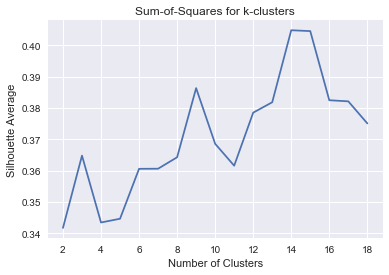

In [118]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

def conduct_silhouette_average_analysis(data, k_max=10, title='title'):
    
    scaled_data = StandardScaler().fit_transform(data)
    component_data = PCA(n_components=2, random_state=45).fit_transform(scaled_data)
   
    k_values = [x for x in range(2, k_max)]
    silhouette_averages = []
    for k in k_values:
        cluster_labels = KMeans(n_clusters=k, random_state=45).fit_predict(component_data)
        silhouette_averages.append(silhouette_score(component_data, cluster_labels))

    ax = plt.plot(k_values, silhouette_averages)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Average')
    plt.title(title)
    save_plot_for_summary_report('silhouette-score.png')
    plt.show()
    
conduct_silhouette_average_analysis(data.drop(axis=1, labels=['animal_id']), 
                                    k_max=19, 
                                    title="Sum-of-Squares for k-clusters")

In [129]:
from sklearn.decomposition import PCA

def conduct_pca_and_kmeans_analysis(data, animal_ids, pca_components=2, n_clusters=3, filename=""):
    random_state = 25
    pca_components = PCA(n_components=pca_components, random_state=random_state).fit_transform(data)
    cluster_labels = KMeans(n_clusters=n_clusters, random_state=random_state).fit_predict(pca_components)
    print()
        
    x = pca_components[:,0]
    y = pca_components[:,1]

    results = pd.DataFrame({'cluster_id':cluster_labels, 'x':x, 'y':y, 'animal_id':animal_ids})

    ax = sns.lmplot('x', 'y', data=results, hue='cluster_id', fit_reg=False, palette=sns.color_palette("cubehelix", n_clusters))
    _ = plt.title(f'Animal Clusters: k-means (k={n_clusters})')
    _ = plt.xlabel("Feature Space for First Feature")
    _ = plt.ylabel("Feature Space for Second Feature")
    save_plot_for_summary_report(filename)

    return results

In [130]:
def generate_profile_results(assignments, top_ids=[], bottom_ids=[]):
    cluster_results = []
    for cluster_id in assignments['cluster_id'].unique():
        cluster_assignments = assignments[assignments['cluster_id'] == cluster_id]
        
        results = {}
        results['cluster_id'] = cluster_id
        results['count_total'] = cluster_assignments['animal_id'].count()
        results['top_total'] = cluster_assignments[cluster_assignments['animal_id'].isin(top_ids)].count()['animal_id']
        results['bot_total'] = cluster_assignments[cluster_assignments['animal_id'].isin(bottom_ids)].count()['animal_id']
        results['bot_percent'] = results['bot_total'] / results['count_total']
        results['top_percent'] = results['top_total'] / results['count_total']
        
        cluster_results.append(results)
        
    columns = ['cluster_id', 'count_total', 'top_total', 'bot_total', 'top_percent', 'bot_percent']
    return pd.DataFrame(cluster_results)[columns].sort_values('cluster_id').set_index('cluster_id')

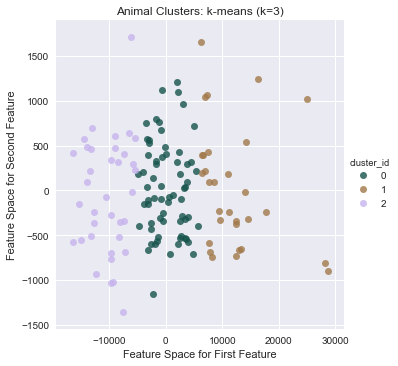

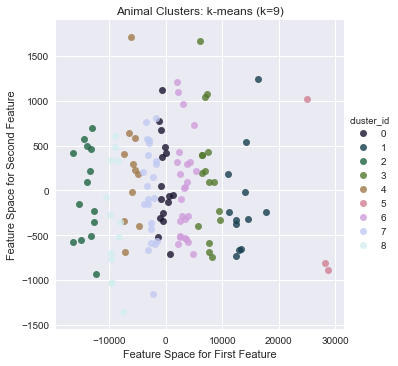

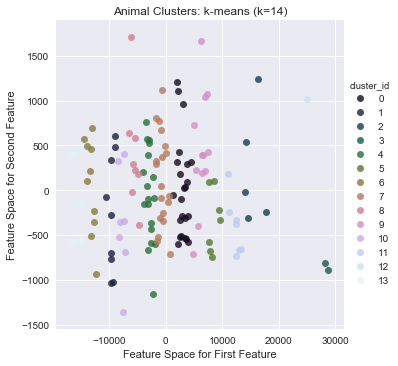

In [141]:
cluster_assigments = {} 
for cluster_count in [3, 9, 14]:
    cluster_assigments[cluster_count] = conduct_pca_and_kmeans_analysis(data=data.drop(axis=1, labels=['animal_id']), 
                                                          animal_ids=data['animal_id'],
                                                          pca_components=2,
                                                          n_clusters=cluster_count,
                                                          filename=f'kmeans-clusters-k-{cluster_count}.png')


In [142]:
for key, assignments in cluster_assigments.items():
    results = generate_profile_results(assignments=assignments, 
                             top_ids=top_producers['animal_id'], 
                             bottom_ids=bottom_producers['animal_id'])
    
    print("\n--------------------------------------------------------------------------")
    print(f"----------- Composition of Cluter Profiles for {key} Clusters ----------------")
    print("--------------------------------------------------------------------------\n")
    
    print(results)


--------------------------------------------------------------------------
----------- Composition of Cluter Profiles for 3 Clusters ----------------
--------------------------------------------------------------------------

            count_total  top_total  bot_total  top_percent  bot_percent
cluster_id                                                             
0                    66          0          0     0.000000     0.000000
1                    30         13          0     0.433333     0.000000
2                    36          0         13     0.000000     0.361111

--------------------------------------------------------------------------
----------- Composition of Cluter Profiles for 9 Clusters ----------------
--------------------------------------------------------------------------

            count_total  top_total  bot_total  top_percent  bot_percent
cluster_id                                                             
0                    16          0        

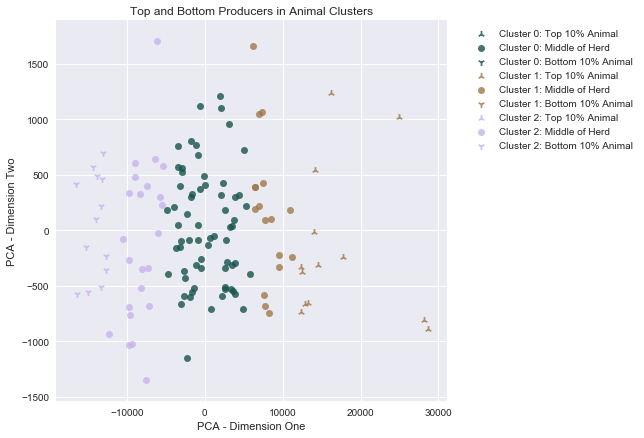

In [150]:
def plot_top_and_bottom_producers_in_clusters(data, bot_ids, top_ids):
    fig, ax = plt.subplots(figsize=(7, 7))
    
    clusters = sorted(data['cluster_id'].unique())
    
    # Generate Boolean Masks for animals in top, and bottom producers
    is_top_producer = data['animal_id'].isin(top_ids)
    is_bottom_producer = data['animal_id'].isin(bot_ids)
    
    # Generate a pallete of colors for the number of clusters
    colors = sns.color_palette("cubehelix", len(clusters))
    
    for cluster in clusters:
        # Get the color for the cluster
        cluster_color = colors[cluster]
        
        # Generate a boolean mask for animals in the current cluster
        is_current_cluster = data['cluster_id'] == cluster
        
        # Plot animals in cluster that are top producers
        plot_data = data[is_current_cluster & is_top_producer]
        _ = sns.regplot('x', 'y', data=plot_data, color=cluster_color, marker='2', ax=ax, fit_reg=False, 
                        label=f'Cluster {cluster}: Top 10% Animal')

        plot_data = data[is_current_cluster & ~is_top_producer & ~is_bottom_producer]
        _ = sns.regplot('x', 'y', data=plot_data, color=cluster_color, marker='o', ax=ax, fit_reg=False, 
                        label=f'Cluster {cluster}: Middle of Herd')
        
        # Plot animals in cluster that are bottom producers
        plot_data = data[is_current_cluster & is_bottom_producer]
        _ = sns.regplot('x', 'y', data=plot_data, color=cluster_color, marker='1', ax=ax, fit_reg=False, 
                        label=f'Cluster {cluster}: Bottom 10% Animal')
        
    _ = plt.title('Top and Bottom Producers in Animal Clusters')
    _ = plt.xlabel("PCA - Dimension One")
    _ = plt.ylabel("PCA - Dimension Two")
    
    # Put legend to side of plot, given large number of components
    ax.legend(bbox_to_anchor=(1.5, 1.00))
    save_plot_for_summary_report('top-and-bottom-producers-clusters.png')
    plt.show()

plot_top_and_bottom_producers_in_clusters(data=cluster_assigments[3], 
                                          bot_ids=bottom_producers['animal_id'], 
                                          top_ids=top_producers['animal_id'])

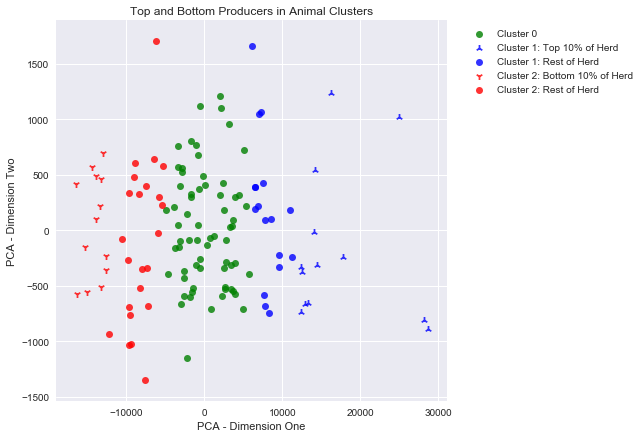

In [137]:
#BACKUP
def plot_top_and_bottom_producers_in_clusters(cluster_assignments, bot_ids, top_ids):
    fig, ax = plt.subplots(figsize=(7, 7))
    cluster_zero = cluster_assignments['cluster_id'] == 0
    cluster_one = cluster_assignments['cluster_id'] == 1
    cluster_two = cluster_assignments['cluster_id'] == 2
    top_producers = cluster_assignments['animal_id'].isin(top_ids)
    bot_producers = cluster_assignments['animal_id'].isin(bot_ids)

    data = cluster_assignments[cluster_zero & ~bot_producers & ~top_producers]
    _ = sns.regplot('x', 'y', data=data, color='g', marker='o', ax=ax, fit_reg=False, label='Cluster 0')
   
    data = cluster_assignments[cluster_one & top_producers]
    _ = sns.regplot('x', 'y', data=data, color='b', marker='2', ax=ax, fit_reg=False, label='Cluster 1: Top 10% of Herd')

    data = cluster_assignments[cluster_one & ~top_producers]
    _ = sns.regplot('x', 'y', data=data, color='b', marker='o', ax=ax, fit_reg=False, label='Cluster 1: Rest of Herd')
    
    data = cluster_assignments[cluster_two & bot_producers]
    _ = sns.regplot('x', 'y', data=data, color='r', marker='1', ax=ax, fit_reg=False, label='Cluster 2: Bottom 10% of Herd')

    data = cluster_assignments[cluster_two & ~bot_producers]
    _ = sns.regplot('x', 'y', data=data, color='r', marker='o', ax=ax, fit_reg=False, label='Cluster 2: Rest of Herd')
    _ = plt.title('Top and Bottom Producers in Animal Clusters')
    _ = plt.xlabel("PCA - Dimension One")
    _ = plt.ylabel("PCA - Dimension Two")
    ax.legend(bbox_to_anchor=(1.5, 1.00))
    save_plot_for_summary_report('top-and-bottom-producers-clusters.png')
    plt.show()

plot_top_and_bottom_producers_in_clusters(cluster_assignments=cluster_assigments[3], 
                                          bot_ids=bottom_producers['animal_id'], 
                                          top_ids=top_producers['animal_id'])

,count_total,top_total,bot_total,top_percent,bot_percent
cluster_id,,,,,
0,1,0,0,0.000000,0.000000
1,21,1,1,0.047619,0.047619
2,15,6,0,0.400000,0.000000
3,16,1,4,0.062500,0.250000
4,15,4,0,0.266667,0.000000
5,25,0,1,0.000000,0.040000
6,20,1,1,0.050000,0.050000
7,19,0,6,0.000000,0.315789


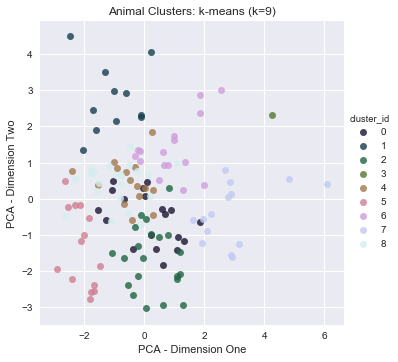

In [56]:
nine_clusters = conduct_pca_and_kmeans_analysis(scaled_data,
                                                      animal_ids,
                                                      pca_components=2,
                                                      n_clusters=8,
                                                      filename='kmeans-clusters-k-8.png')
generate_profile_results(nine_clusters, top_ids, bot_ids)

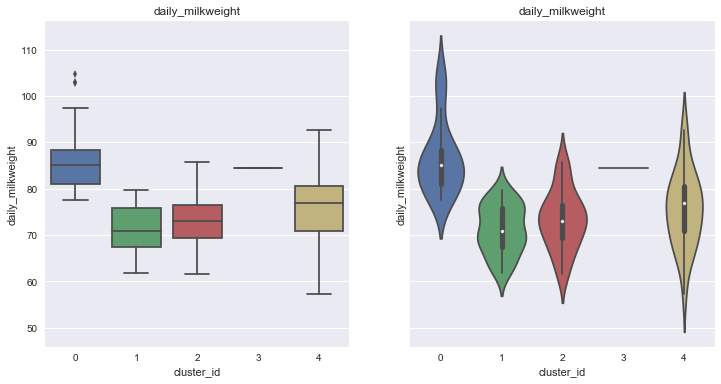

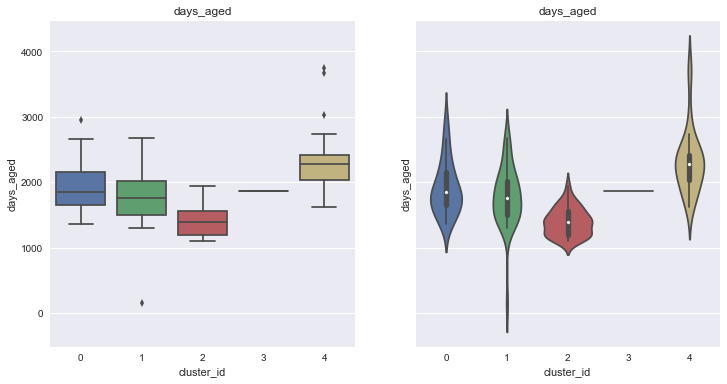

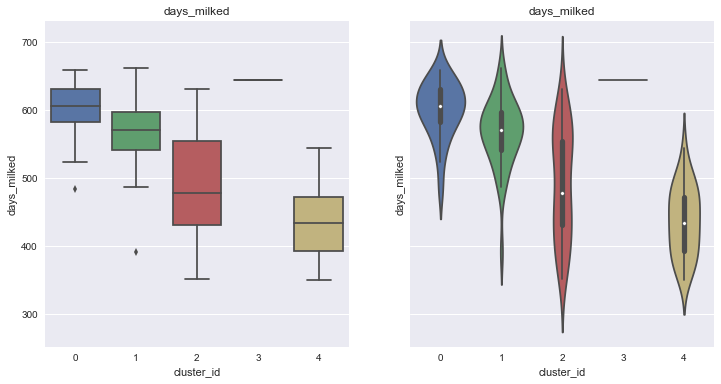

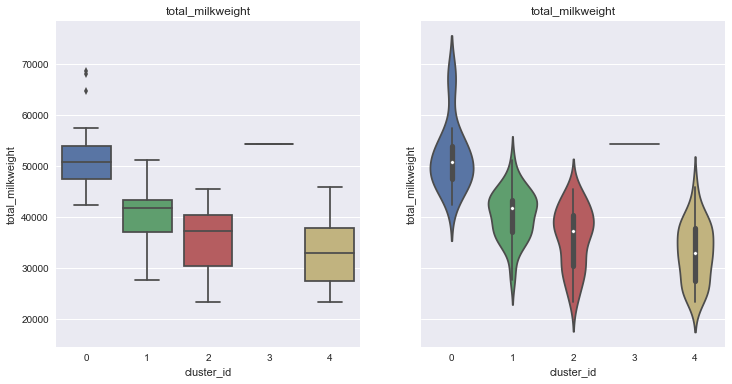

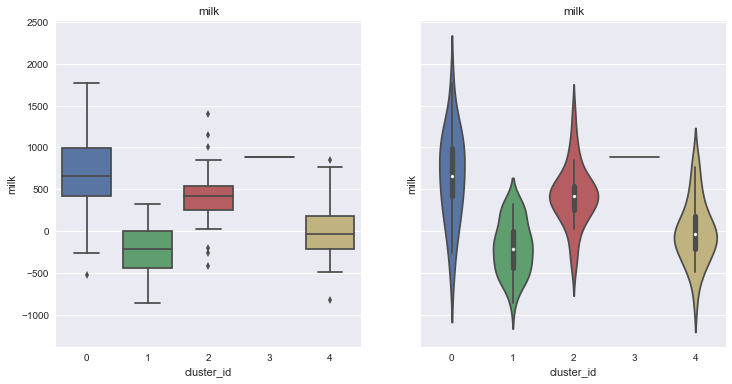

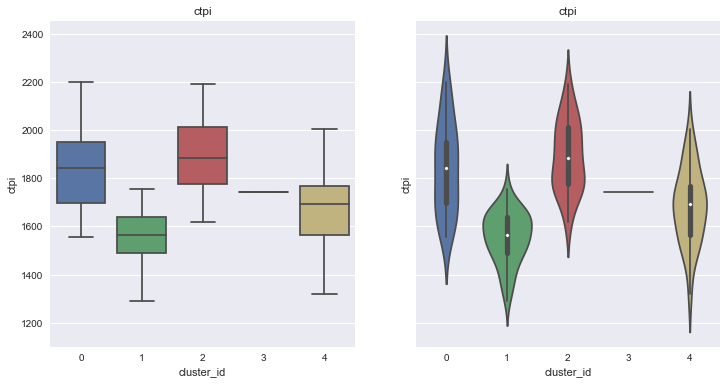

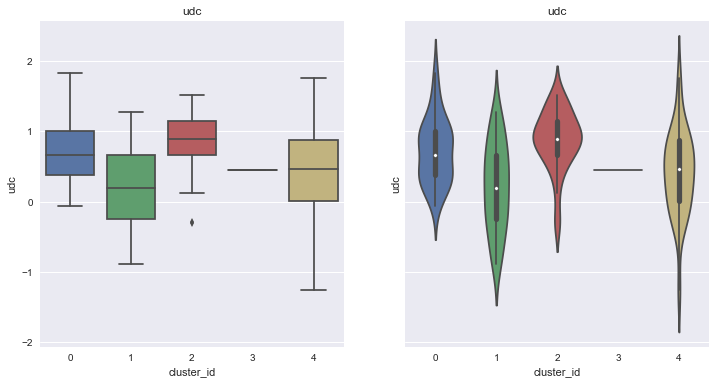

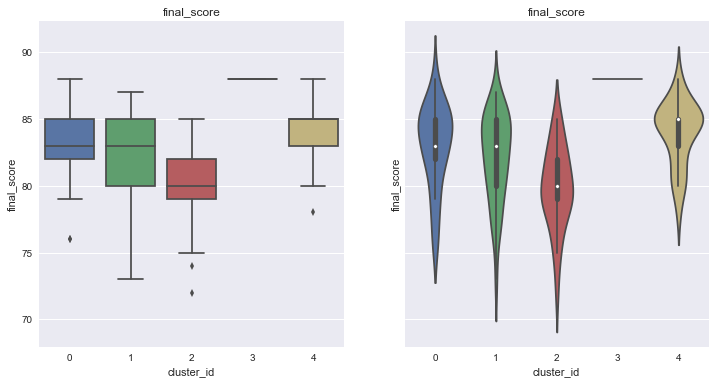

In [57]:
clusters_plus_data = pd.merge( left=five_clusters, right=data, left_on='animal_id', right_on='animal_id')

for var in clusters_plus_data.columns[4:12]:
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,6))
    ax1.set_title(var)
    ax2.set_title(var)
    sns.boxplot(x="cluster_id", y=var, data=clusters_plus_data, ax=ax1)
    sns.violinplot(x="cluster_id", y=var, data=clusters_plus_data, ax=ax2)

[(0.08523511613408935, 0.32661779003565533, 0.2973201282529313),
 (0.63284224750184226, 0.4747981096220677, 0.29070209208025455),
 (0.77795651814553435, 0.70694219425997518, 0.93144060840431908)]